In [13]:
#hide
#default_exp examples.dummy_experiment_manager
from nbdev.showdoc import *
from dsblocks.utils.nbdev_utils import nbdev_setup, TestRunner

nbdev_setup ()
tst = TestRunner (targets=['dummy'])

# Dummy Experiment Manager

> Dummy experiment manager

In [14]:
#export
import numpy as np
import joblib

In [15]:
#for tests
import pytest
import numpy as np
import pandas as pd
from dsblocks.utils.nbdev_utils import md

## FakeModel

In [16]:
#export
class FakeModel (object):
    
    overfitting_epochs = 20
    
    def __init__ (self, offset=0.5, rate=0.01, epochs=10, noise=0.0, verbose=True):
        # hyper-parameters
        self.offset = offset
        self.rate = rate
        self.epochs = epochs
        
        # fake internal weight
        self.weight = 0
        
        # fake accuracy
        self.accuracy = 0
        
        # noise
        self.noise = noise
        
        # other parameters
        self.verbose = verbose
        
        self.history = {}
        self.current_epoch = 0
        self.dict_results = None
    
    def fit (self):
        number_epochs = int(self.epochs)
        if self.verbose:
            print (f'fitting model with {number_epochs} epochs')
        
        if self.current_epoch==0:
            self.accuracy = self.offset
        
        for epoch in range(number_epochs):
            self.weight += self.rate
            if self.current_epoch < self.overfitting_epochs:
                self.accuracy += self.rate
            else:
                self.accuracy -= self.rate
            if self.verbose:
                print (f'epoch {epoch}: accuracy: {self.accuracy}')
            
            # increase current epoch by 1
            self.current_epoch += 1
            
            # we keep track of the evolution of different metrics to later be able to visualize it
            self.store_intermediate_metrics ()
    
    def store_intermediate_metrics (self):
        validation_accuracy, test_accuracy = self.score()
        if 'validation_accuracy' not in self.history:
            self.history['validation_accuracy'] = []
        self.history['validation_accuracy'].append(validation_accuracy)
        
        if 'test_accuracy' not in self.history:
            self.history['test_accuracy'] = []
        self.history['test_accuracy'].append(test_accuracy)
        
        if 'accuracy' not in self.history:
            self.history['accuracy'] = []
        self.history['accuracy'].append(self.accuracy)
        
        self.dict_results = dict (accuracy=self.accuracy,
                                  validation_accuracy=validation_accuracy,
                                  test_accuracy=test_accuracy)
        
    def save_model_and_history (self, path_results):
        joblib.dump (self.weight, f'{path_results}/model_weights.pk')
        joblib.dump (self.history, f'{path_results}/model_history.pk')
        joblib.dump (self.dict_results, f'{path_results}/dict_results.pk')
        
    def load_model_and_history (self, path_results):
        if os.path.exists(f'{path_results}/model_weights.pk'):
            print (f'reading model from {path_results}/model_weights.pk')
            self.weight = joblib.load (f'{path_results}/model_weights.pk')
            self.history = joblib.load (f'{path_results}/model_history.pk')
            self.current_epoch = len(self.history['accuracy'])
            if self.current_epoch > 0:
                self.accuracy = self.history['accuracy'][-1]
            else:
                self.accuracy = self.offset
        else:
            print (f'model not found in {path_results}')
        
    def retrieve_score (self):
        if self.dict_results is None:
            self.dict_results = joblib.load (f'{path_results}/dict_results.pk')
        return self.dict_results['validation_accuracy'], self.dict_results['test_accuracy']
    
    def score (self):
        # validation accuracy
        validation_accuracy = self.accuracy + np.random.randn() * self.noise
        
        # test accuracy
        if self.current_epoch < 10:
            test_accuracy = self.accuracy + 0.1
        else:
            test_accuracy = self.accuracy - 0.1
        test_accuracy = test_accuracy + np.random.randn() * self.noise
        
        # make accuracy be in interval [0,1] 
        validation_accuracy = max(min(validation_accuracy, 1.0), 0.0)
        test_accuracy = max(min(test_accuracy, 1.0), 0.0)
        
        return validation_accuracy, test_accuracy
    
    # fake load_data which does nothing
    def load_data (self):
        pass
    


## DummyExperimentManager

In [17]:
#export
from hpsearch.experiment_manager import ExperimentManager
import hpsearch
import os
from hpsearch.visualization import plot_utils 

class DummyExperimentManager (ExperimentManager):

    def __init__ (self, 
                  path_experiments=None, 
                  folder=None,
                  metric='validation_accuracy',
                  op='max',
                  **kwargs):
        
        if path_experiments is None: path_experiments = f'{os.path.dirname(hpsearch.__file__)}/../results'
        
        super().__init__ (path_experiments=path_experiments, 
                          folder=folder,
                          metric=metric,
                          op=op,
                          **kwargs)

    def run_experiment (self, parameters={}, path_results='./results'):
        # extract hyper-parameters used by our model. All the parameters have default values if they are not passed.
        offset = parameters.get('offset', 0.5)   # default value: 0.5
        rate = parameters.get('rate', 0.01)   # default value: 0.01
        epochs = parameters.get('epochs', 10) # default value: 10
        noise = parameters.get('noise', 0.0)
        
        # other parameters that do not form part of our experiment definition
        # changing the values of these other parameters, does not make the ID of the experiment change
        verbose = parameters.get('verbose', True)
        
        # build model with given hyper-parameters
        model = FakeModel (offset=offset, rate=rate, epochs=epochs, noise = noise, verbose=verbose)
        
        # load training, validation and test data (fake step)
        model.load_data()
        
        # fit model with training data 
        model.fit ()
        
        # save model weights and evolution of accuracy metric across epochs
        model.save_model_and_history(path_results)
        
        # evaluate model with validation and test data
        validation_accuracy, test_accuracy = model.retrieve_score()
        
        # store model
        self.model = model
        
        # the function returns a dictionary with keys corresponding to the names of each metric. 
        # We return result on validation and test set in this example
        dict_results = dict (validation_accuracy = validation_accuracy,
                             test_accuracy = test_accuracy)
        
        return dict_results
    
    # implementing the following method is not necessary but recommended
    def get_default_parameters (self, parameters):
        """Indicate the default value for each of the hyper-parameters used."""
        defaults = dict(offset=0.5,
                        rate=0.01,
                        epochs=10)
        
        if parameters.get('rate', defaults['rate']) < 0.001:
            defaults.update (epochs=100)
        
        return defaults
    
    def experiment_visualization (self, experiments=None, run_number=0, 
                                  name_file='model_history.pk', metric='test_accuracy', backend='matplotlib', 
                                  **kwargs):
        path_experiments = self.path_experiments
        traces = []
        for experiment_id in experiments:
            path_results = self.get_path_results (experiment_id, run_number=run_number)
            if os.path.exists('%s/%s' %(path_results, name_file)):
                history = joblib.load('%s/%s' %(path_results, name_file))
                label = '{}'.format(experiment_id)
                traces = plot_utils.add_trace ((1-np.array(history[metric]))*20, style='A.-', label=label, 
                                               backend=backend, traces=traces)
        plot_utils.plot(title=metric, xlabel='epoch', ylabel=metric, traces=traces, backend=backend)

## Helper functions for testing purposes

### run_multiple_experiments

In [18]:
# export
def run_multiple_experiments (nruns=1, noise=0.0, verbose=True, rate=0.03, values_to_explore=None,
                              other_parameters={}, EM=DummyExperimentManager, em=None, em_args={}, 
                              **kwargs):
    if em is None:
        em = EM (**kwargs)
    parameters_single_value = dict(rate=rate, noise=noise)   # parameters where we use a fixed value
    if values_to_explore is None:
        parameters_multiple_values=dict(offset=[0.1, 0.3, 0.6], epochs=[5, 15, 30]) # parameters where we try multiple values
    else:
        parameters_multiple_values=values_to_explore
    other_parameters_original = other_parameters
    other_parameters = dict (verbose=verbose) # parameters that control other aspects that are not part of our experiment definition (a new experiment is not created if we assign different values for these parametsers)
    other_parameters.update (other_parameters_original)
    em.grid_search (log_message='fixed rate, multiple epochs values',
            parameters_single_value=parameters_single_value,
            parameters_multiple_values=parameters_multiple_values,
            other_parameters=other_parameters,
            nruns=nruns, 
            **em_args)

### generate_data

In [19]:
#export
def generate_data (name_folder, parameters_multiple_values=None, 
                   parameters_single_value=None, other_parameters={}, verbose=0, em_args={}, **kwargs):
    np.random.seed (42)
    path_experiments=f'test_{name_folder}/default'
    manager_path = f'{path_experiments}/managers'
    em = DummyExperimentManager (path_experiments=path_experiments, manager_path=manager_path,
                                 verbose=verbose, **kwargs)
    em.remove_previous_experiments (parent=True)
    run_multiple_experiments (em=em, nruns=5, noise=0.1, verbose=False,
                              values_to_explore=parameters_multiple_values, 
                              parameters_single_value=parameters_single_value, 
                              other_parameters=other_parameters,  em_args=em_args)
    return em

### remove_previous_experiments

In [20]:
# export 
import shutil
import os

def remove_previous_experiments (EM=DummyExperimentManager):
    em = EM ()
    em.remove_previous_experiments (parent=True)

### Usage

In [21]:
#exports tests.examples.test_dummy_experiment_manager
def test_dummy_experiment_manager ():
    em = generate_data ('dummy_experiment_manager')
    df = em.get_experiment_data ()
    display (df)

    # check that stored parameters are correct
    par = lambda parameter: (dflt.parameters_col, parameter, '')
    assert (df[par('epochs')].values == np.array([ 5.,  5.,  5., 15., 15., 15., 30., 30., 30.])).all()
    assert (df[par('offset')].values == np.array([0.1, 0.3, 0.6, 0.1, 0.3, 0.6, 0.1, 0.3, 0.6])).all()
    assert (df[par('rate')].values == 0.03).all()

    # check that the accuracy values are correct
    epochs_before_overfitting = 20
    epochs_test = 10
    for experiment_id in df.index:
        if df.loc[experiment_id, par('epochs')] < epochs_before_overfitting:
            accuracy = (df.loc[experiment_id, par('offset')] + 
                        df.loc[experiment_id, par('rate')] * df.loc[experiment_id, par('epochs')])
        else:
            epochs_after_overfitting = df.loc[experiment_id, par('epochs')]-epochs_before_overfitting
            accuracy = (df.loc[experiment_id, par('offset')] + 
                        df.loc[experiment_id, par('rate')] * 
                        (epochs_before_overfitting  - epochs_after_overfitting))
        if df.loc[experiment_id, par('epochs')] < epochs_test:
            test_accuracy = accuracy + 0.1
        else:
            test_accuracy = accuracy - 0.1
        validation_accuracy = max(min(accuracy, 1.0), 0.0)
        test_accuracy = max(min(test_accuracy, 1.0), 0.0)

        #assert np.abs(df.loc[experiment_id, '0_validation_accuracy'] - validation_accuracy) <1.e-10, f"experiment {experiment_id}: {df.loc[experiment_id, '0_validation_accuracy']} == {validation_accuracy}" 
        #assert np.abs(df.loc[experiment_id, '0_test_accuracy'] - test_accuracy) <1.e-10

        md ('check that model history is written correcly')
        path_experiment = em.get_path_results (3, 0)
    model = FakeModel()
    model.load_model_and_history(path_experiment)
    assert np.max(np.abs(model.history['accuracy']-np.arange(0.13, 0.55, 0.03))) < 1e-10

    em.experiment_visualization ([3,4,5], backend='matplotlib')

    em.remove_previous_experiments (parent=True)

write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class


running test_dummy_experiment_manager


write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
write_manager failed

,epochs,noise,offset,rate,0_validation_accuracy,0_test_accuracy,time_0,date,0_finished,1_validation_accuracy,...,time_2,2_finished,3_validation_accuracy,3_test_accuracy,time_3,3_finished,4_validation_accuracy,4_test_accuracy,time_4,4_finished
0,5.0,0.1,0.1,0.03,0.165416,0.186901,0.000261,23:43:47.965462,True,0.279750,...,0.000220,True,0.272119,0.290240,0.000250,True,0.262308,0.253578,0.000232,True
1,5.0,0.1,0.3,0.03,0.424554,0.655272,0.000236,23:43:48.128042,True,0.391349,...,0.000261,True,0.455782,0.494078,0.000241,True,0.405904,0.689830,0.000259,True
2,5.0,0.1,0.6,0.03,0.866023,0.935186,0.000246,23:43:48.304497,True,0.766725,...,0.000256,True,0.751755,0.853721,0.000241,True,0.559847,0.829214,0.000227,True
3,15.0,0.1,0.1,0.03,0.480570,0.547520,0.000268,23:43:48.479228,True,0.441828,...,0.000456,True,0.587014,0.425928,0.000295,True,0.417939,0.514744,0.000272,True
4,15.0,0.1,0.3,0.03,0.640378,0.684274,0.000271,23:43:48.665994,True,0.726948,...,0.000257,True,0.821807,0.643263,0.000281,True,0.643857,0.892138,0.000288,True
5,15.0,0.1,0.6,0.03,1.000000,0.915646,0.000264,23:43:48.872428,True,1.000000,...,0.000292,True,1.000000,0.816340,0.000286,True,1.000000,1.000000,0.000277,True
6,30.0,0.1,0.1,0.03,0.376854,0.240772,0.000371,23:43:49.090257,True,0.311273,...,0.000333,True,0.452882,0.401411,0.000335,True,0.450969,0.407243,0.000326,True
7,30.0,0.1,0.3,0.03,0.633139,0.558434,0.000322,23:43:49.311086,True,0.490737,...,0.000331,True,0.522213,0.457843,0.000333,True,0.473186,0.590243,0.000336,True
8,30.0,0.1,0.6,0.03,0.639091,0.723841,0.000356,23:43:49.540507,True,0.964388,...,0.000337,True,1.000000,0.746543,0.000333,True,0.960270,0.716715,0.000345,True


check that model history is written correcly

check that model history is written correcly

check that model history is written correcly

check that model history is written correcly

check that model history is written correcly

check that model history is written correcly

check that model history is written correcly

check that model history is written correcly

check that model history is written correcly

reading model from test_dummy_experiment_manager/experiments/00003/0/model_weights.pk


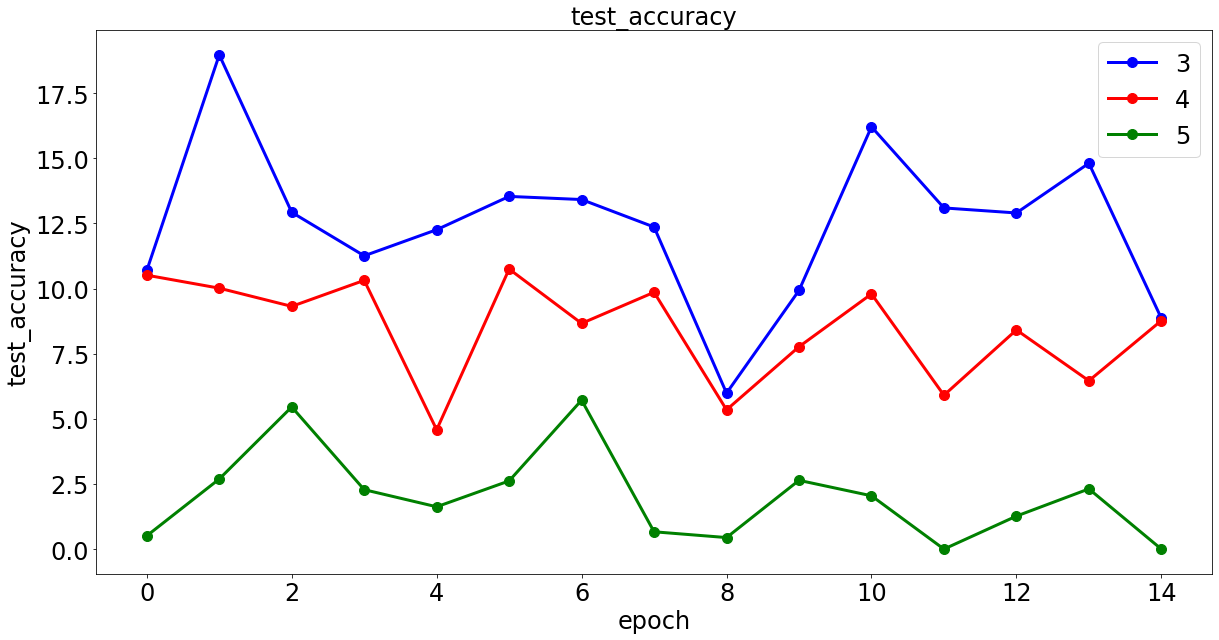

In [22]:
tst.run (test_dummy_experiment_manager, tag='dummy')